Loan Default Prediction Using Machine Learning Part-2

1. Hyperparameter tuning (GridSearchCV/ RandomizedSearchCV)

In [ ]:
import pandas as pd
loan_train = pd.read_csv('train_data.csv')

In [ ]:
import pandas as pd

loan_train = pd.read_csv('/content/train_data.csv')
loan_train.drop('Loan_ID', axis=1, inplace=True)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Loading dataset
loan_train = pd.read_csv('/content/train_data.csv')

#Dropping the unnecessary columns
loan_train.drop('Loan_ID', axis=1, inplace=True)

#Encoding all categorical columns (object types)
le = LabelEncoder()
for col in loan_train.columns:
    if loan_train[col].dtype == 'object':
        loan_train[col] = le.fit_transform(loan_train[col].astype(str))

#Split features and target
X = loan_train.drop('Loan_Status', axis=1)
y = loan_train['Loan_Status']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [100, 150],
    'max_depth' : [None, 10, 20],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2]
}

rf = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1

)

grid_search.fit(X_train_scaled, y_train)

print('Best Parameters Found:', grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_best_rf_pred = best_rf.predict(X_test_scaled)

print('Tuned RF Accuracy:', accuracy_score(y_test, y_best_rf_pred))
print('\nclassification_report:\n', classification_report(y_test, y_best_rf_pred))
print('\nconfusion_matrix:\n', confusion_matrix (y_test, y_best_rf_pred))

Tuned RF Accuracy: 0.7804878048780488

classification_report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123


confusion_matrix:
 [[18 25]
 [ 2 78]]


2. Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv = 5, scoring = 'f1')

print('Cross-Validated F! Scores:', cv_scores)
print('Mean F1 Score:', np.mean(cv_scores))
print('Standard Deviation:', np.std(cv_scores))

Cross-Validated F! Scores: [0.92517007 0.86666667 0.84722222 0.87012987 0.87581699]
Mean F1 Score: 0.8770011641020045
Standard Deviation: 0.02593240236857164


3. Feature Selection (Recursive Feature Elimination)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np

#Loading and dropping Loan_ID
loan_train = pd.read_csv('/content/train_data.csv')
loan_train.drop('Loan_ID', axis=1, inplace = True)

#Encoding categorical columns
df = loan_train.copy()
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

#Imputing missing values
imputer = SimpleImputer(strategy = 'median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

#Spliting data
X = df_imputed.drop('Loan_Status', axis=1)
y = df_imputed['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Inputing missing values
log_reg = LogisticRegression(max_iter = 1000)
rfe_selector = RFE(estimator = log_reg, n_features_to_select=8)
rfe_selector.fit(X_train_scaled, y_train)

#Printing
selected_features = X.columns[rfe_selector.support_]
print("Selected Features:\n", selected_features)


✅ Selected Features:
 Index(['Gender', 'Married', 'Dependents', 'Education', 'CoapplicantIncome',
       'LoanAmount', 'Credit_History', 'Property_Area'],
      dtype='object')


4. Explainability {SHAP (SHaply Additive exPlanations)}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#Loading and dropping
df = pd.read_csv('/content/train_data.csv')
df.drop('Loan_ID', axis=1, inplace=True)

#Label encoding all objects in the columns
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

#Imputing missing values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

#Splitting
X = df_imputed.drop('Loan_Status', axis = 1)
y = df_imputed['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
selected_features = ['Gender', 'Married', 'Dependents', 'Education',
                     'CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Property_Area']


<class 'numpy.ndarray'> 123


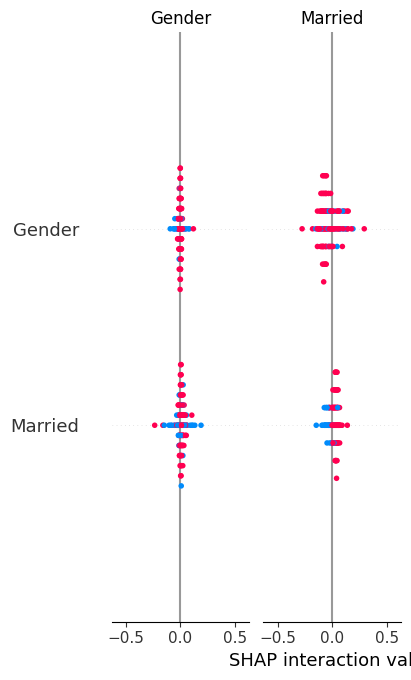

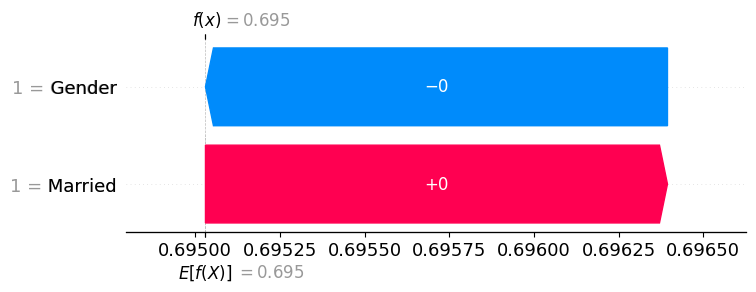

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#Training the model
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(X_train[selected_features], y_train)

#SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test[selected_features])

#For binary classification: pick class 1 (Loan Approved)
#Checking length of shap_values
print(type(shap_values), len(shap_values))

#If it's a list, use shap_values[1], otherwise use shap_values directly
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test[selected_features], plot_type = "dot")
else:
    shap.summary_plot(shap_values, X_test[selected_features], plot_type = "dot")

plt.show()

shap.plots.waterfall(shap.Explanation(values=shap_values[1][0],
                                      base_values = explainer.expected_value[1],
                                      data=X_test[selected_features].iloc[0]))


5. Saving/Loading Best Models with joblib or pickle

In [ ]:
import joblib

joblib.dump(rf_model, 'loan_prediction_model.pkl')

#Loaded the model back
loaded_model = joblib.load('loan_prediction_model.pkl')

#Predicting using loaded model
loaded_model.predict(X_test[selected_features])


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1.])

Streamlit Web App

To enhance the usability and interactivity of the project, we built a simple yet effective web application using Streamlit — a popular Python library for creating custom web apps for machine learning and data science projects.

 App File: loan_prediction_app.py

This app allows users to input applicant details (such as income, credit history, education, etc.) through an intuitive interface and get a real-time prediction of whether the applicant is likely to default on the loan.

Key Features :

- Clean and responsive user interface
- Real-time prediction using the trained model (loan_approval_model.pkl)
- Input validation and friendly error handling
- Integrated visuals for better interpretability

Run this App Locally :-

Download some of the packages for eg :- streamlit, imblearn, etc

And then launch the app on your local machine using :-
streamlit run loan_prediction_app.py

This will open the app in your browser where you can test prediction live.

Note :- The app was developed using features derived from a publicly available loan prediction dataset on Kaggle. Inputs are structured to match the original dataset schema to ensure model compatibility.

-- This app makes the project more interactive and accessible, demonstrating how machine learning can be applied in real-world financial decision systems.